##cài thư viện cần thiết

In [ ]:
!pip install sentence-transformers scikit-learn

##load và xử lý dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd

# Đọc file đã upload sẵn lên Colab
with open("/content/drive/MyDrive/LLM/mt5/train.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Tạo DataFrame
df = pd.DataFrame(data)

# Gộp claim + evidence thành một trường
df["text"] = df["claim"] + " " + df["evidence"]

# Chuyển nhãn: SUPPORTS -> 0, REFUTES -> 1
df["label"] = df["label"].map({"SUPPORTS": 0, "REFUTES": 1})

# Xem nhanh
df[["text", "label"]].head()


,text,label
0,Sự mất tập trung của Michael Jordan trong trận...,1
1,"Trong năm 2022, chiến tranh Nga - Ukraine làm ...",0
2,Bức tượng 'David' của Donatello cao hơn bức tư...,1
3,Việt Nam đã ban hành luật mới về điện để thúc ...,0
4,Vinfast chuẩn bị ra mắt xe máy điện sạc 5 phút...,1


##encode toàn bộ dữ liệu

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

embeddings = model.encode(df["text"].tolist(), convert_to_tensor=False, show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/303 [00:00<?, ?it/s]

In [ ]:
##Huấn luyện mô hình phân loại

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(embeddings, df["label"].tolist())


LogisticRegression(max_iter=1000)

##Lưu mô hình đã huấn luyện

In [ ]:
import joblib

# Lưu model LogisticRegression
joblib.dump(clf, "/content/drive/MyDrive/LLM/distiluse-base-multilingual-cased-v2/logistic_model.joblib")

# Lưu vectorizer Sentence-BERT theo tên mô hình
model.save("/content/drive/MyDrive/LLM/distiluse-base-multilingual-cased-v2/sentence_model")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load mô hình đã huấn luyện

In [ ]:
import joblib
from sentence_transformers import SentenceTransformer

clf = joblib.load("/content/drive/MyDrive/LLM/distiluse-base-multilingual-cased-v2/logistic_model.joblib")
sentence_model = SentenceTransformer("/content/drive/MyDrive/LLM/distiluse-base-multilingual-cased-v2/sentence_model")

##Load và xử lý val.json

In [ ]:
import json
import pandas as pd

# Đọc file val.json đã upload
with open("/content/drive/MyDrive/LLM/mt5/test.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

test_df = pd.DataFrame(val_data)

# Gộp văn bản
test_df["text"] = test_df["claim"] + " " + test_df["evidence"]

# Chuẩn hóa nhãn: SUPPORTS → 0, REFUTES → 1
test_df["label"] = test_df["label"].map({"SUPPORTS": 0, "REFUTES": 1})

##Encode và dự đoán

In [ ]:
# Mã hóa văn bản val
test_embeddings = sentence_model.encode(test_df["text"].tolist(), convert_to_tensor=False, show_progress_bar=True)

# Dự đoán nhãn
test_preds = clf.predict(test_embeddings)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

##Đánh giá mô hình

=== Báo cáo phân loại ===
              precision    recall  f1-score   support

    SUPPORTS     0.7564    0.8343    0.7935       670
     REFUTES     0.7638    0.6660    0.7116       539

    accuracy                         0.7593      1209
   macro avg     0.7601    0.7502    0.7525      1209
weighted avg     0.7597    0.7593    0.7570      1209



<ipython-input-13-e23ac66e882b>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


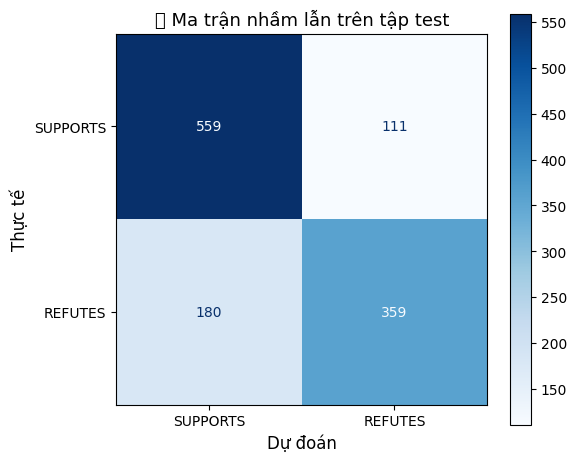

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Đánh giá mô hình
print("=== Báo cáo phân loại ===")
print(classification_report(test_df["label"], test_preds, digits=4, target_names=["SUPPORTS", "REFUTES"]))

# Tạo confusion matrix
cm = confusion_matrix(test_df["label"], test_preds)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["SUPPORTS", "REFUTES"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, values_format='d')

# Thêm tiêu đề và nhãn bằng tiếng Việt
plt.title("📊 Ma trận nhầm lẫn trên tập test", fontsize=13)
plt.xlabel("Dự đoán", fontsize=12)
plt.ylabel("Thực tế", fontsize=12)
plt.tight_layout()
plt.show()
